# importing stuff

In [48]:
import numpy as np
import tensorflow as tf
import keras
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt
import itertools, os, shutil, random, glob, warnings # glob finds file name pattern / shutil provided support file copying and removal...



# creation of train, validation and test datasets

the model gets the files from a subset of folders and interprets the labels by the folders of the already classified and organized images
```
├── data   
    ├── train
    |   ├── cat      
    |   ├── dog  
    |
    ├── validation
    |   ├── cat
    |   ├── dog
    |
    ├── test
        ├── cat
        ├── dog
```


In [12]:
if os.path.isdir('dogs-vs-cats/train/dog') is False:
    for i in ['train/dog', 'train/cat', 'test/dog', 'test/cat', 'valid/dog', 'valid/cat']:
        os.makedirs('dogs-vs-cats/'+i)

try:
    for img in random.sample(glob.glob('dogs-vs-cats/cat*'), 500):
        shutil.move(img, 'dogs-vs-cats/train/cat')

    for img in random.sample(glob.glob('dogs-vs-cats/dog*'), 500):
        shutil.move(img, 'dogs-vs-cats/train/dog')

    for img in random.sample(glob.glob('dogs-vs-cats/cat*'), 100):
        shutil.move(img, 'dogs-vs-cats/valid/cat')

    for img in random.sample(glob.glob('dogs-vs-cats/dog*'), 100):
        shutil.move(img, 'dogs-vs-cats/valid/dog')

    for img in random.sample(glob.glob('dogs-vs-cats/cat*'), 50):
        shutil.move(img, 'dogs-vs-cats/test/cat')

    for img in random.sample(glob.glob('dogs-vs-cats/dog*'), 50):
        shutil.move(img, 'dogs-vs-cats/test/dog')
except: pass

In [15]:
train_path = './dogs-vs-cats/train'
test_path = './dogs-vs-cats/test'
valid_path = './dogs-vs-cats/valid'

# setting the files to batches
the way that the models understands the files, plus a builtin preprocessing of images, each batch will contain 10 images

In [43]:
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=train_path, target_size=(224,224), classes=['cat', 'dog'], batch_size=10, shuffle=True)

valid_batches =  ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=valid_path, target_size=(224,224), classes=['cat', 'dog'], batch_size=10, shuffle=True)

test_batches =  ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=test_path, target_size=(224,224), classes=['cat', 'dog'], batch_size=10, shuffle=False)

Found 1000 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


In [34]:
imgs, labels = next(train_batches)

def plotImages(images_arr): # function proposed by tensorflow to show the batches
    fig, axes = plt.subplots(1,10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

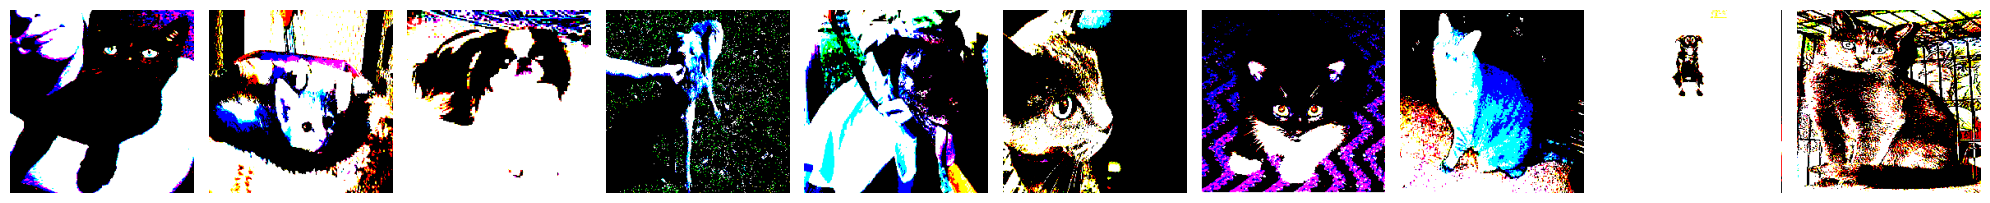

array([[1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.]], dtype=float32)

In [38]:
plotImages(imgs) 
display(labels)

# building the model itself
it's composed of 2 packs of a convolutional layer plus a MaxPool.  
the model afterwards needs to be compiles and then fitted.  
This model in particular didnt work so well, with alow accuracy of validation of around 60%. Which indicates a overfitting on the training dataset.  
After that, we'll 'import' a already working model. 

In [39]:
model = Sequential([
    Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same', input_shape=(224,224,3)),
    MaxPool2D(pool_size=(2,2), strides=2),
    Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same'),
    MaxPool2D(pool_size=(2,2), strides=2),
    Flatten(), Dense(units=2, activation='softmax')
])

2023-07-04 16:00:21.126855: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [40]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 200704)            0         
                                                                 
 dense (Dense)               (None, 2)                 4

In [53]:
if os.path.isfile('./catdog_model.h5') is False:
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
    model.fit(x=train_batches, validation_data=valid_batches, epochs=10, verbose=2)
    if os.path.isfile('./catdog_model.h5') is False:
        model.save('./catdog_model.h5')

else: imported_model = load_model('./catdog_model.h5') 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

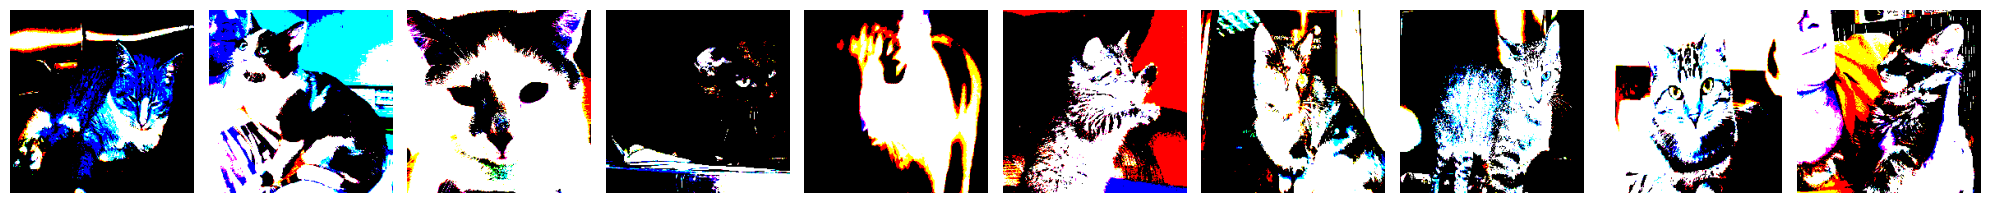

[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [54]:
test_imgs, test_labels = next(test_batches)
plotImages(test_imgs)
print(test_labels)

In [56]:
predictions = model.predict(test_batches, verbose=0)
np.round(predictions)

2023-07-04 16:40:16.469448: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


array([[0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.

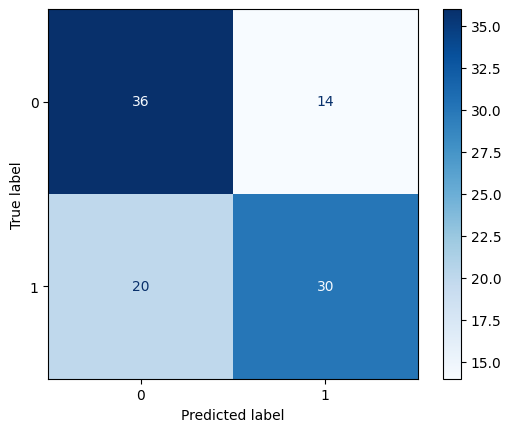

In [85]:
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions,axis=-1))

ConfusionMatrixDisplay(cm).plot(cmap='Blues');

# importing VGG16 model

In [86]:
vgg16_model = tf.keras.applications.vgg16.VGG16()

2023-07-04 17:21:04.712991: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 411041792 exceeds 10% of free system memory.
2023-07-04 17:21:05.289364: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 411041792 exceeds 10% of free system memory.
2023-07-04 17:21:05.909368: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 411041792 exceeds 10% of free system memory.


553467096/553467096 [==============================] - 110s 0us/step


2023-07-04 17:23:00.125566: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 411041792 exceeds 10% of free system memory.


In [89]:
vgg16_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [93]:
print(type(model), type(vgg16_model), sep='\n')

<class 'keras.engine.sequential.Sequential'>
<class 'keras.engine.functional.Functional'>


note that these two model have different properties, as the past model being a Sequential model, and the VGG being a API called Model, which is far more complicated for now, so we're going to 'transform' it to a sequential model -->

In [98]:
model = Sequential()

for layer in vgg16_model.layers[:-1]:
    model.add(layer)

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)      

In [99]:
for layer in model.layers:
    layer.trainable=False 
''' 
setting the layer to be non trainable because its already trained, 
but it has  a lot of classes, rather than just cat and dogs. After that
we add a new Dense layer, that will set our predictions to be just cats and dogs.
That means just this layer will have a trainable parameters, as we can see in the summary.
'''
model.add(Dense(units=2, activation='softmax'))
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)      

                                                                 
 block5_conv1 (Conv2D)       (None, 14, 14, 512)       2359808   
                                                                 
 block5_conv2 (Conv2D)       (None, 14, 14, 512)       2359808   
                                                                 
 block5_conv3 (Conv2D)       (None, 14, 14, 512)       2359808   
                                                                 
 block5_pool (MaxPooling2D)  (None, 7, 7, 512)         0         
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 fc1 (Dense)                 (None, 4096)              102764544 
                                                                 
 fc2 (Dense)                 (None, 4096)              16781312  
                                                                 
 dense_3 (

In [101]:
model.compile(optimizer=Adam(learning_rate=.0001), loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(x=train_batches, validation_data=valid_batches, epochs=2, verbose=2)

Epoch 1/2


2023-07-04 17:46:43.066945: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


100/100 - 363s - loss: 0.0611 - accuracy: 0.9790 - val_loss: 0.0627 - val_accuracy: 0.9850 - 363s/epoch - 4s/step
Epoch 2/2
100/100 - 368s - loss: 0.0332 - accuracy: 0.9900 - val_loss: 0.0591 - val_accuracy: 0.9700 - 368s/epoch - 4s/step


In [102]:
vgg_pred = model.predict(test_batches, verbose=0)
vgg_cm = confusion_matrix(test_batches.classes, y_pred=np.argmax(vgg_pred, axis=-1))
display(vgg_cm)


2023-07-04 17:59:01.254793: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


array([[49,  1],
       [ 2, 48]])